# Generative Modeling for Relational Databases


The following notebook addresses a data-frame generation technique that uses a statistical generative model. It focuses on a standalone table meaning that the aim is to model the table independently of any other data. 

The number of attributes (number of columns) of the table will be referred to as $n$.

This method will apply the following steps:

- Data loading
- Data pre-processing (converting categorical attributes to numerical)
- Modeling and generation 
- Data post-processing (converting back numerical generated values to categorical)
- Quality assessment of the generated data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import scipy.stats as stats
from tqdm import tqdm
from scipy.stats import exponweib
from math import sqrt
from scipy.stats.stats import pearsonr
import sys
sys.path.insert(1, '../../')
import warnings
warnings.filterwarnings('ignore')

## 1. Loading Data

Loading a dataset

In [2]:
%%sh
ls -laFh ../../data/statistical-generative-modeling-sample.csv.bz2

-rw-r--r-- 1 auriane auriane 4,4M juil.  7 14:58 ../../data/statistical-generative-modeling-sample.csv.bz2


In [3]:
df = pd.read_csv("../../data/statistical-generative-modeling-sample.csv.bz2")

In [4]:
df

,SEATS,PASSENGERS,FREIGHT,DISTANCE,RAMP_TO_RAMP,AIR_TIME,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,AIRCRAFT_TYPE,MONTH,Unnamed: 14
0,0.0,0.0,331088.0,216.0,1708.0,780.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12402,ITO,620,6,NaN
1,0.0,0.0,1081490.0,163.0,5695.0,1782.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12758,KOA,620,6,NaN
2,0.0,0.0,570900.0,102.0,2006.0,884.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12982,LIH,620,6,NaN
3,0.0,0.0,1206131.0,100.0,6146.0,1704.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,13830,OGG,620,6,NaN
4,0.0,0.0,180778.0,216.0,2135.0,1092.0,1TQ,Rhoades Aviation dba Transair,12402,ITO,12173,HNL,620,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394121,105984.0,81424.0,511764.0,100.0,34737.0,17951.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,3,NaN
394122,106368.0,74321.0,143112.0,100.0,33693.0,19865.0,HA,Hawaiian Airlines Inc.,13830,OGG,12173,HNL,608,10,NaN
394123,106752.0,71430.0,600636.0,100.0,35319.0,18013.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,10,NaN
394124,107904.0,77703.0,478682.0,100.0,34822.0,18338.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,5,NaN


For the purpose of this demonstration we reduce the size of the dataset in order to reduce computation times. The number of attributes is also reduced to focus on illustrative purposes.

In [5]:
reduced_size = 500

In [6]:
df_sample = df[["DISTANCE", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]][:reduced_size]

We display the reduced data-frame:

In [7]:
df_sample

,DISTANCE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,216.0,12173,12402
1,163.0,12173,12758
2,102.0,12173,12982
3,100.0,12173,13830
4,216.0,12402,12173
...,...,...,...
495,122.0,10551,14282
496,145.0,10551,14718
497,38.0,10551,15257
498,117.0,10551,15282


## 2. Useful functions

Following are some useful functions that will be used throughout this notebook:

Draws a value according to a gaussian truncated distribution with given parameters:

In [8]:
from tools import gauss_truncated

Functions for graphical display:

In [9]:
from common_structure import remove_ticks, remove_splines, modify_splines

Checks if a matrix is symmetric, and positive definite:

In [10]:
def is_symmetric(M, rtol=1e-05, atol=1e-08):
    return np.allclose(M, M.T, rtol=rtol, atol=atol)

def is_pos_def(M):
    return np.all(np.linalg.eigvals(M) > 0)

Computes Cholesky decomposition of symmetric positive definite matrix:

In [11]:
def cholesky(M):
    
    """
    Performs Cholesky decomposition of a matrix
    :param M: symmetric and positive definite matrix
    :return: lower triangular matrix L from the decomposition
    """
        
    assert is_symmetric(M), "The matrix for Cholesky decomposition is not symmetric"
    assert is_pos_def(M), "The matrix for Cholesky decomposition is not positive definite"
    
    n = len(M)
    L = np.zeros((n, n))

    # performs the Cholesky decomposition
    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): 
                L[i][k] = sqrt(M[i][i] - tmp_sum)
            else:
                L[i][k] = (1.0 / L[k][k] * (M[i][k] - tmp_sum))
    return L

## 3. Data pre-processing

### Converting categorical data to numerical 

In [12]:
from data_processing import categorical_to_numerical

The dataset from which we want to generate data might contain different types of values:
- Numerical: values that have meaning as a measurement (distance, gross weight etc.)
- Categorical: a collection of information that is divided into groups (origin country code, etc.). They can take numerical values but those numbers don't have mathematical meaning

For example, in our toy data-frame, "ORIGIN_AIRPORT_ID" and "DEST_AIRPORT_ID" are categorical data.

The issue is that a statistical model cannot be directly built from categorical data. This is why we have to convert categorical data to numerical.

_To do: automate getting categorical fields thanks to metadata. For now, categorical attributes manually assessed in the categorical_fields list._

In [13]:
categorical_fields = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]

All categorical attributes are converted to numerical [0,1] values using the following method:
- Discrete values are first sorted in descending order based on their proportion in the dataset. 
- The [0,1] interval is split into disjoint sections $[a_c,b_c]$ based on the proportion of each category c. 

Then to convert a categorical attribute we follow these steps for each row:
- we find the interval $[a_c, b_c]$ that corresponds to the categorical value.
- we sample a numerical value from a truncated Gaussian distribution with $\mu$ as the center of the interval and $\sigma = \frac{b_c-a_c}{6}$

In [14]:
df_sample_num, transitional_dfs = categorical_to_numerical(df_sample, categorical_fields)

We display the sample data-frame where categorical fields (here there are two: "ORIGIN_AIRPORT_ID" and "DEST_AIRPORT_ID") have been converted to numerical fields:

In [15]:
df_sample_num

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,216.0,0.419072,0.493744
1,163.0,0.421534,0.501610
2,102.0,0.422091,0.536285
3,100.0,0.413294,0.442785
4,216.0,0.535268,0.245280
...,...,...,...
495,122.0,0.249906,0.920339
496,145.0,0.272372,0.994269
497,38.0,0.243875,0.896851
498,117.0,0.246399,0.768310


## 4. Modeling and generation

We can now start building our model. 

We will first begin by computing for each attribute, the distribution and parameters (according to a predefined list of known distributions) that best fits the empirical distribution.

We will then convert all of the column distributions to standard normal distributions, in order to compute the covariance matrix of different attributes without any bias that would be induced by the shapes of the distributions. 


After this is done, we can generate new rows.

In [16]:
from common_structure import Model, Distribution

In [17]:
class Statistical_generative_model(Model):
    
    """
    Implements statistical generative model
    """
    
    def gaussian_copula(self):

            """
            Converts all column distributions to standard normal 
            """

            if self.distr_computed:

                # going through the rows
                for index, row in self.df.iterrows():
                    values = {}
                    initial_vect = np.array(row)
                    transformed_vect = np.zeros(len(initial_vect))

                    #going through the columns
                    for i, attribute in enumerate(self.df):

                        # getting distribution of the column
                        distr = getattr(stats, self.distributions[attribute].distribution_name)
                        param = self.distributions[attribute].param
                        norm = getattr(stats, "norm")

                        # converting value to get standard normal distribution
                        transformed_vect[i] = norm.ppf(distr.cdf(initial_vect[i], *param[:-2], loc=param[-2], \
                                                                 scale=param[-1]))
                        #transformed_vect[i] = norm.ppf(distr.cdf(initial_vect[i]))
                        values[attribute] = transformed_vect[i]

                    # adding normed results to a new data-frame
                    new_row = pd.Series(values, name="new row")
                    self.df_normed = self.df_normed.append(new_row, ignore_index=True)

                with pd.option_context('mode.use_inf_as_null', True):
                    self.df_normed = self.df_normed.dropna()

            else:
                raise ValueError('Must compute the distributions first.')            


    def sample(self):

        """
        :return: generated_row, numpy array (data-frame row) computed as a sample of the modeled distribution
        """

        if not self.df_normed.empty:

            # computing covariance matrix for the normed data-frame
            cov_matrix = self.df_normed.cov()
            cov_matrix = np.array(cov_matrix)
            nb_col = self.df_normed.shape[1]

            # computing cholesky decomposition
            L = cholesky(cov_matrix)

            mean = np.zeros(nb_col)
            cov = np.eye(nb_col)

            # generating new vector according to formula
            V = np.random.multivariate_normal(mean, cov)
            U = L@V
            generated_row = np.zeros(nb_col)
            for i, attribute in enumerate(self.df):
                distr = getattr(stats, self.distributions[attribute].distribution_name)  
                param = self.distributions[attribute].param
                norm = getattr(stats, "norm")
                generated_row[i] = distr.ppf(norm.cdf(U[i]), *param[:-2], loc=param[-2], scale=param[-1])

            return generated_row

        else:
            raise ValueError ("Must run gaussian_copula method first.")


    def generate_data(self, size):

        """
        Generates a data-frame of required size
        :param size: int, number of rows that will be generated
        :return: pandas data-frame with generated values
        """

        df_gen = pd.DataFrame(columns=self.df.columns)
        for index in range(size):
            values = {}
            row = self.sample()
            for i, attribute in enumerate(df_gen):
                values[attribute] = row[i]
            new_row = pd.Series(values, name="new row")
            df_gen = df_gen.append(new_row, ignore_index=True)
        return df_gen

### Fitting distributions to attributes

We create a Model instance for our toy data-frame.

We compute the best fitted distribution (and associated parameters) for each attribute of our toy data-frame. 

To do so we use a predefined list of distributions. For each type of distribution, we use the fit method of scipy.stats in order to compute the best parameters.

Then, for each type of distribution and associated parameters, we use the __Kolmgorov-Smirnov test__ from scipy.stats to determine which distribution fits the best.

The idea behind this method is that the empirical cdf of an attribute $X_n = (X_1, ..., X_n)$ can be computed trough the following formula, $\forall x \in \mathbb{R}$:
$$\hat{F}_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}_{X_i \leq x} $$
The test is built on the following hypothesis ($F$ being the unknown distribution of our empirical data, and $F_0$ being one of our predefined well-known distributions): 
$$H_0 = \{F = F_0\}, \quad H_1 = \{F \neq F_0\}$$
With the statistic:
$$\xi_n = \underset{x \in \mathbb{R}}{\sup} |\hat{F}_n(x) - F(x)|$$

We compute this test for all of our known distributions and associated $F_0$, and define the best distribution as the one that has the __higher p-value__ for this test. Indeed, for a given value of the test statistic, the p-value assesses how likely it is that this value be due to random fluctuations of the sample: the smaller the p-value, the more unlikely the realization under $H_0$ (and the more we should be encouraged to reject $H_0$). In other words, the p-value represents the likelihood that the data matches a particular distribution.

In [18]:
Mod = Statistical_generative_model(df_sample_num)
Mod.compute_distributions()

The distribution that fits the best attribute DISTANCE is expon
The pvalue is 0.011450506829860175  with the following parametrers: (0.0, 778.388)


The distribution that fits the best attribute ORIGIN_AIRPORT_ID_NUM is exponweib
The pvalue is 0.7711061127035297  with the following parametrers: (0.0074206309848471015, 133.3462483480451, 0.006654843458747693, 0.9902887791960546)


The distribution that fits the best attribute DEST_AIRPORT_ID_NUM is exponweib
The pvalue is 0.9048024172776893  with the following parametrers: (0.027938329865824466, 35.527085743090225, 0.00964190826248549, 0.9720152979980461)




In order to be able to compare visually, we plot for each attribute the empirical distribution, and its corresponding fitted distribution.

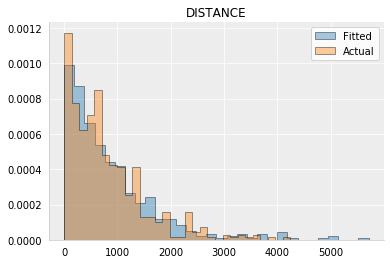

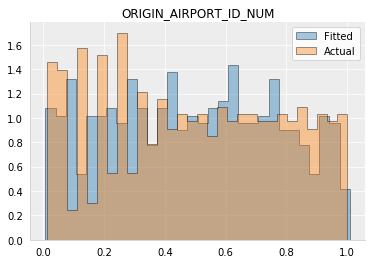

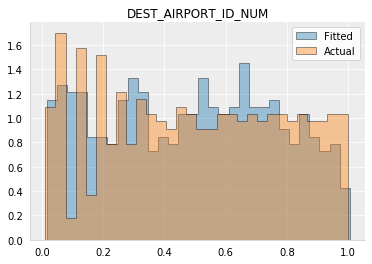

In [19]:
Mod.plot_distributions()

### Gaussian copula to normalize the data

We perform a Gaussian Copula method in order to convert all of the column distributions to standard normal distributions so that the covariance matrix $M$ of the data-frame can be computed without any bias that would be induced by the distribution's shape.



In order to do so we go through the table row by row and consider each row as a vector:
$$X = [x_0, ..., x_{n-1}]$$
We convert the row using the following formula:
$$[x_0, ..., x_{n-1}] \leftarrow [\phi^{-1}(F_0(x_0)), ..., \phi^{-1}(F_{n-1}(x_{n-1}))]$$

Where $\forall i \in \{0, ..., n-1\} $, $F_i$ is the cumulative distribution function (cdf) of our fitted distribution for attribute $i$, and $\phi^{-1}$ is the inverse cdf of the standard normal distribution.

In [20]:
Mod.gaussian_copula()

We display the normalized data-frame:

In [21]:
Mod.df_normed

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,-0.698853,-0.201114,0.001572
1,-0.881828,-0.194768,0.021811
2,-1.161018,-0.193334,0.111221
3,-1.172189,-0.216042,-0.129960
4,-0.698853,0.093690,-0.690345
...,...,...,...
495,-1.057820,-0.676758,1.522743
496,-0.954320,-0.606624,2.488363
497,-1.668116,-0.696164,1.358677
498,-1.082301,-0.688011,0.778787


We plot the histograms of distributions in Copula space in order to visually check that they follow standard normal distributions.

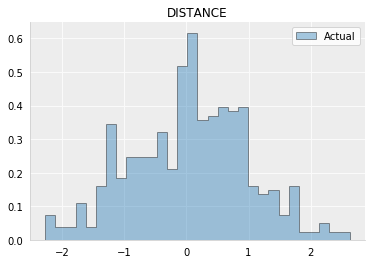

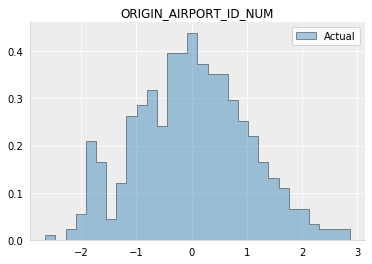

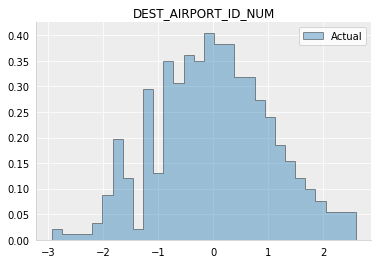

In [22]:
Mod2 = Model(Mod.df_normed)
Mod2.compute_distributions(display_results=False)
Mod2.plot_distributions(fitted_distr=False)

### Data generation

We can then generate new rows. The idea is to draw samples according to the covariance matrix in copula space M, and then convert these samples back to the original space. To do so, we use the following algorithm for each row:
- we generate a random vector V of size $(n-1)$ x $1$ of uncorrelated random variables with each random variable $V_i$ is normal with zero mean and unit covariance $1$. We notice that as V has zero mean, the covariance matrix of V can be written:

$$C(V) = \mathbb{E}(VV^T) = I_n$$

- In order to generate a random vector whose covariance matrix is M, we perform the Cholesky decomposition of M (this is possible since by definition the covariance is symmetric and positive definite): 

$$M = LL^T$$ 

- We then compute the vector $U = LV$. $U$ __has by construction M as covariance matrix__. Indeed, as $\mathbb{E}(V) = 0$, we have $\mathbb{E}(U) = 0$ and:

$$C(U) = \mathbb{E}(UU^T) = \mathbb{E}(LVV^TL^T) = L\mathbb{E}(VV^T)L^T = LL^T = M$$

- We then go back to the original space by applying the inverse of the Gaussian Copula:

$$[u_0, ..., u_{n-1}] \leftarrow [F_0^{-1}(\phi (u_0)), ..., F_{n-1}^{-1}(\phi (u_{n-1}))]$$

We choose the number of sample we would like to generate:

In [23]:
size_of_generation = 500

In [24]:
df_gen = Mod.generate_data(size_of_generation)

In [25]:
df_gen

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,1397.581309,0.296537,0.385016
1,491.475092,0.844114,0.553400
2,1124.856260,0.345834,0.445076
3,880.409426,0.042349,0.889298
4,431.029534,0.095423,0.717785
...,...,...,...
495,92.423141,0.527246,0.810454
496,2264.470396,0.297490,0.066858
497,29.814976,0.607381,0.321464
498,59.137207,0.222399,0.756375


## 5. Data post-processing

We can then convert back our categorical data from numerical to categorical, by using the intervals we had defined during the pre-processing.

In order to do so, for a value $v \in [0, 1]$, we simply compute the interval it belongs to and return the associated discrete category.

In [26]:
from data_processing import numerical_to_categorical

In [27]:
numerical_to_convert = ["ORIGIN_AIRPORT_ID_NUM", "DEST_AIRPORT_ID_NUM"]

In [28]:
df_final = numerical_to_categorical(df_gen, numerical_to_convert, transitional_dfs)

In [29]:
df_final

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,1397.581309,14275.0,13303.0
1,491.475092,12917.0,12266.0
2,1124.856260,10299.0,13830.0
3,880.409426,16091.0,10298.0
4,431.029534,13061.0,14853.0
...,...,...,...
495,92.423141,15304.0,14736.0
496,2264.470396,14275.0,16091.0
497,29.814976,14814.0,13244.0
498,59.137207,11193.0,15534.0


## 6. Quality assessment

The quality assessment of generated data has two components.
- The first one is how close is the generated dataset from the original data. This will determine whether the generated dataset is suitable for substituting the original data for processing ans analysis.
- The second component is privacy. The idea is to make sure that the generated synthetic dataset preserves anonymity and does not contain identifiable data.

### Closeness to real data

In [30]:
from data_viz import Closeness

In order to assess closeness between the generated and initial dataset, we use a quantitative method by computing pairwise Pearson's correlation coefficients for both datasets and comparing them. We also use a qualitative method by plotting relationships between attributes.

In [31]:
res = Closeness(df_sample_num, df_gen)

Quantitative measurement:

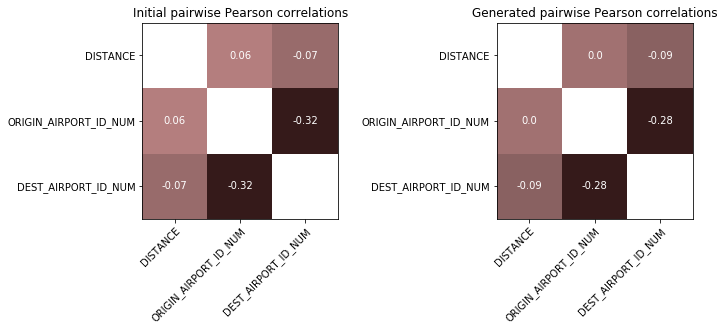

In [32]:
res.pearson_plot()

Qualitative measurement:

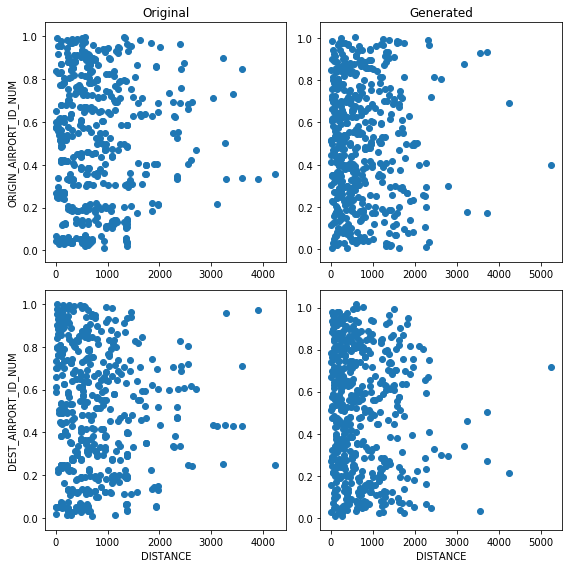

In [33]:
res.variables_scatter_plot()

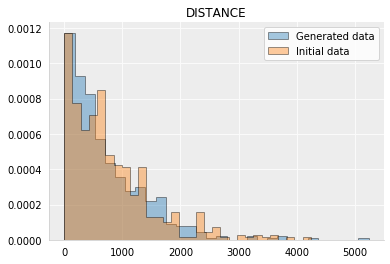

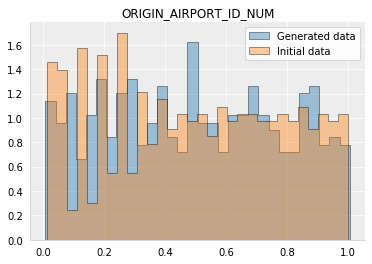

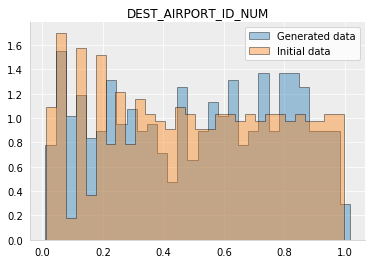

In [34]:
res.compare_distributions()